# Note:  
V1 
- Create flow of modelling with Naive Bayes (Gaussian Naive Bayes).

In [49]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

seed_no = 572

import warnings
warnings.filterwarnings("ignore")

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Load data

In [51]:
df_trn = pd.read_csv('data/x_train_82.csv', index_col='index')
df_tst = pd.read_csv('data/x_test_82.csv', index_col='index')

In [52]:
print(df_trn.shape, df_tst.shape)
df_trn.head()

(847, 8) (212, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,medium
824,6.8,45,0,0,0,1,255,medium
602,5.6,50,0,1,1,1,255,low
347,8.6,55,0,1,1,1,255,low
753,6.6,38,0,0,0,0,255,medium


# Preprocessing function

In [53]:
def encode_label(df_in):
    df_fnc = df_in.copy()
    df_fnc.loc[df_fnc['Grade']=='low', 'Grade'] = 0
    df_fnc.loc[df_fnc['Grade']=='medium', 'Grade'] = 1
    df_fnc.loc[df_fnc['Grade']=='high', 'Grade'] = 2
    df_fnc['Grade'] = df_fnc['Grade'].astype(int)
    
    return df_fnc

df_trn = encode_label(df_trn)
df_tst = encode_label(df_tst)

In [54]:
df_trn.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,1
824,6.8,45,0,0,0,1,255,1


In [55]:
# Prepare for training
y_trn = df_trn[['Grade']]
X_trn = df_trn.drop(columns='Grade')

y_tst = df_tst[['Grade']]
X_tst = df_tst.drop(columns='Grade')

print(y_trn.shape, X_trn.shape)
print(y_tst.shape, X_tst.shape)

(847, 1) (847, 7)
(212, 1) (212, 7)


In [56]:
# Scaler
scaler = StandardScaler()
X_trn_scale = pd.DataFrame(scaler.fit_transform(X_trn))
X_trn_scale.columns = X_trn.columns
X_trn_scale.index = X_trn.index

X_tst_scale = pd.DataFrame(scaler.transform(X_tst))
X_tst_scale.columns = X_tst.columns
X_tst_scale.index = X_tst.index

In [57]:
X_trn_scale.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
index,,,,,,,
244,-0.091649,-0.607768,0.902056,-0.882843,0.691509,-0.989430,0.744513
824,0.122987,0.067163,-1.108579,-0.882843,-1.446112,1.010683,0.744513


# Train model

## CV - Hyperparameters tuning

In [59]:
# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# No specific hyperparameters for tuning with Gaussian Naive Bayes

# Fit the model
nb_classifier.fit(X_trn_scale, y_trn)

model_best_params = nb_classifier  # just for easy to run the code continuously

## Retrain the whole training data with the best parameters

In [60]:
# GridSearchCV return the retrained model with whole dataset
y_trn_pred = model_best_params.predict(X_trn_scale)

## Evaluate the model/log score
print(classification_report(y_trn, y_trn_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       343
           1       0.96      0.62      0.75       299
           2       0.61      1.00      0.76       205

    accuracy                           0.83       847
   macro avg       0.85      0.85      0.82       847
weighted avg       0.89      0.83      0.84       847



## Performance on Test data

In [61]:
# Make predictions on the test set
y_test_pred = model_best_params.predict(X_tst_scale)

# Evaluate the model
accuracy = accuracy_score(y_tst, y_test_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_tst, y_test_pred))

Accuracy: 0.8207547169811321
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        86
           1       0.94      0.61      0.74        75
           2       0.59      0.98      0.74        51

    accuracy                           0.82       212
   macro avg       0.84      0.83      0.81       212
weighted avg       0.88      0.82      0.83       212



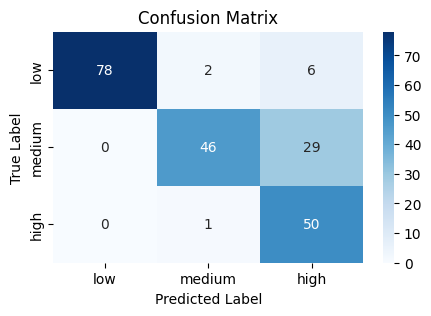

In [62]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_tst, y_test_pred)

# Display the confusion matrix using a heatmap
class_names = ['low', 'medium', 'high']
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# EDA Error (Testing dataset)

In [63]:
# Merge prediction with the testing dataset
df_test_perf = y_tst.copy()
df_test_perf['pred_test'] = y_test_pred
df_test_perf = X_tst.merge(df_test_perf, left_index=True, right_index=True)

# Explore Error
df_error = df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]
print(f"Number of False Prediction: {df_error.shape[0]} ({(100*df_error.shape[0]/y_tst.shape[0]):.02f}%)")
df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]

Number of False Prediction: 38 (17.92%)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade,pred_test
index,,,,,,,,,
907,6.8,40,1,0,1,0,245,1,2
693,6.5,35,1,0,1,0,246,1,2
71,6.8,40,1,0,1,0,245,1,2
719,6.5,36,0,0,1,0,255,1,2
338,6.7,45,1,1,1,0,245,1,2
92,6.6,50,0,0,0,0,255,0,1
717,6.8,40,1,0,1,0,245,1,2
471,6.5,38,1,0,1,0,255,1,2
383,6.8,40,1,0,1,0,245,1,2
